In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.labelsize"] = 17
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [2]:
pd_options = dict(
    sep="\s+",
    usecols=[*range(7)],
    index_col=0,
    names=["ID","I","V","P","dP","t0","ptp"],
    na_values="-"
)
base = {}
files = {}
labels = {}
tables = {}
stats = {}

base["lmc"] = "ogle4/OCVS/lmc/cep/"
files["lmc"] = ["cepF.dat","cep1O.dat","cep2O.dat",
         "cepF1O.dat","cep1O2O.dat","cepF1O2O.dat",
         "cep1O2O3O.dat","cep1O3O.dat","cep2O3O.dat"]

base["smc"] = "ogle4/OCVS/smc/cep/"
files["smc"] = ["cepF.dat","cep1O.dat","cep2O.dat",
         "cepF1O.dat","cep1O2O.dat","cep1O2O3O.dat"]

In [3]:
for cloud,basepath in base.items():
    labels[cloud] = [f[3:].split(".")[0] for f in files[cloud]]
    tables[cloud] = {
        label:pd.read_table(basepath+fname,**pd_options) for fname,label in zip(files[cloud],labels[cloud])
    }
    for label,table in tables[cloud].items():
        for phot in "IV":
            table.insert(len(table.columns),"n"+phot,np.nan)
            for index in table.index:
                try:
                    with open(f"{basepath}phot/{phot}/{index}.dat","r") as file:
                        table.at[index,"n"+phot] = file.read().count("\n")
                except FileNotFoundError:
                    pass
    all_data = pd.concat(tables[cloud]).sort_index()
    tables[cloud]["total"] = all_data
    
    local_stats = {}
    for label,table in tables[cloud].items():
        local_stats[label] = {
            "n":len(table),
            "I":sum(~table["nI"].isna()),
            "I (only)":sum(~table["nI"].isna() & table["nV"].isna()),
            "V":sum(~table["nV"].isna()),
            "V (only)":sum(table["nI"].isna() & ~table["nV"].isna()),
            "both": sum(~table["nI"].isna() & ~table["nV"].isna()),
            "none": sum(table["nI"].isna() & table["nV"].isna())
        }
    stats[cloud] = pd.DataFrame.from_dict(local_stats,orient="index")

In [9]:
pers = tables['lmc']['total'].P
min(1/pers),max(1/pers)

(0.007475000235462508, 4.536818093556448)

In [12]:
len(np.arange(0.001,4.7,1e-4))

46990

In [229]:
sum(~tables['lmc']['F'].nI.isna() & tables['lmc']['F'].nV.isna())

151

In [230]:
sum(tables['lmc']['F'].nI.isna() & ~tables['lmc']['F'].nV.isna())

10

In [235]:
print(stats["lmc"].to_latex())
print(stats["smc"].to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &     n &     I &  I (only) &     V &  V (only) &  both &  none \\
\midrule
F      &  2477 &  2428 &       151 &  2287 &        10 &  2277 &    39 \\
1O     &  1776 &  1766 &       116 &  1650 &         0 &  1650 &    10 \\
2O     &    26 &    26 &         0 &    26 &         0 &    26 &     0 \\
F1O    &    95 &    95 &         6 &    89 &         0 &    89 &     0 \\
1O2O   &   322 &   321 &        16 &   305 &         0 &   305 &     1 \\
F1O2O  &     1 &     1 &         0 &     1 &         0 &     1 &     0 \\
1O2O3O &     7 &     7 &         0 &     7 &         0 &     7 &     0 \\
1O3O   &     1 &     1 &         0 &     1 &         0 &     1 &     0 \\
2O3O   &     1 &     1 &         0 &     1 &         0 &     1 &     0 \\
total  &  4706 &  4646 &       289 &  4367 &        10 &  4357 &    50 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrrrrrr}
\toprule
{} &     n &     I &  I (only) &     V &  V (only) &  both &  none \\
\midrule
F    

In [59]:
files["selected"] = [*reversed(["cepF.dat","cep1O.dat","cep2O.dat","cepF1O.dat","cep1O2O.dat"])]
labels["selected"] = [f[3:].split(".")[0] for f in files["selected"]]
# courtesy of https://learnui.design/tools/data-color-picker.html#palette
#colors = [*reversed(["#003f5c","#58508d","#bc5090","#ff6361","#ffa600"])] 
#colors = [*reversed(["#00876c","#88c580","#ffff9d","#f7a258","#d43d51"])]
colors = ["#00876c","#89bd73","#ffeb8a","#f59855","#d43d51"][::-1]

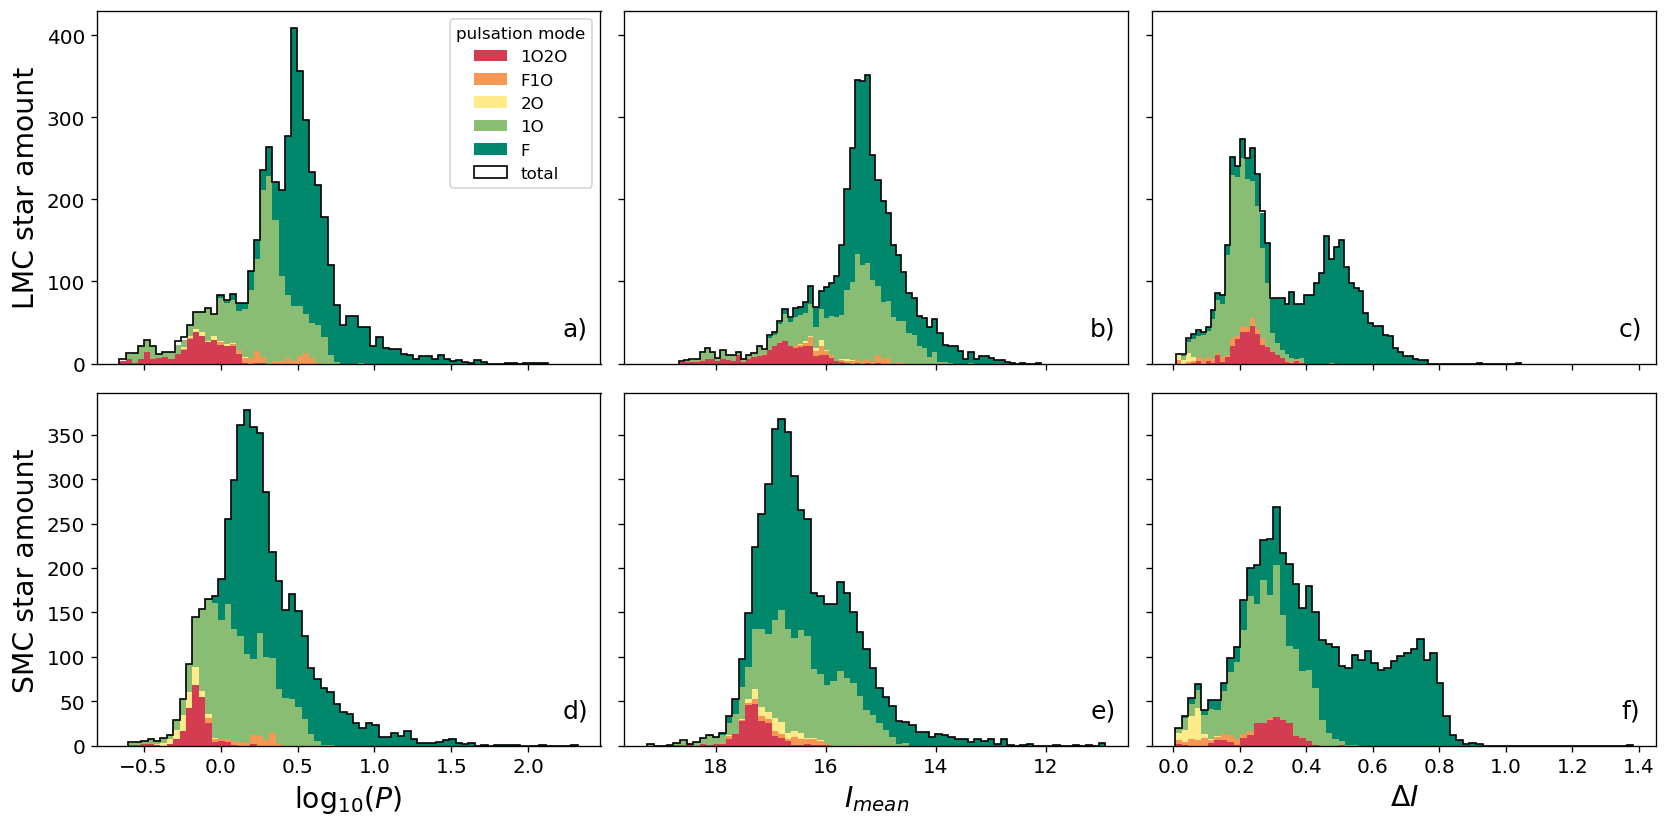

In [92]:
hist_options = dict(stacked=True,bins=70,color=colors,label=labels["selected"])
total_hist_options = dict(bins=70,histtype="step",color='k',label="total")

fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(14,7),sharey="row",sharex="col")

for i,cloud in enumerate(["lmc","smc"]):
    ax = axes[i]
    #
    plt.sca(ax[0])
    plt.hist([np.log10(tables[cloud][s].P) for s in labels["selected"]], **hist_options)
    plt.hist(np.log10(tables[cloud]["total"].P), **total_hist_options)
    if i:
        plt.xlabel(r"$\log_{10}(P)$")
    plt.ylabel(fr"{cloud.upper()} star amount")
    #
    plt.sca(ax[1])
    plt.hist([tables[cloud][s].I for s in labels["selected"]], **hist_options)
    plt.hist(tables[cloud]["total"].I, **total_hist_options)
    if i:
        plt.xlabel(r"$I_{mean}$")
        plt.xlim(np.flip(plt.gca().get_xlim()))
    #    
    plt.sca(ax[2])
    plt.hist([tables[cloud][s].ptp for s in labels["selected"]], **hist_options)
    plt.hist(tables[cloud]["total"].ptp, **total_hist_options)
    if i:
        plt.xlabel(r"$\Delta I$")

sublabels = "abcdef"
for i,ax in enumerate(axes.ravel()):
    plt.sca(ax)
    plt.text(0.95, 0.1, sublabels[i]+")", fontsize=15,
             horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes)
    
plt.sca(axes[0,0])
plt.legend(title="pulsation mode")
plt.tight_layout()

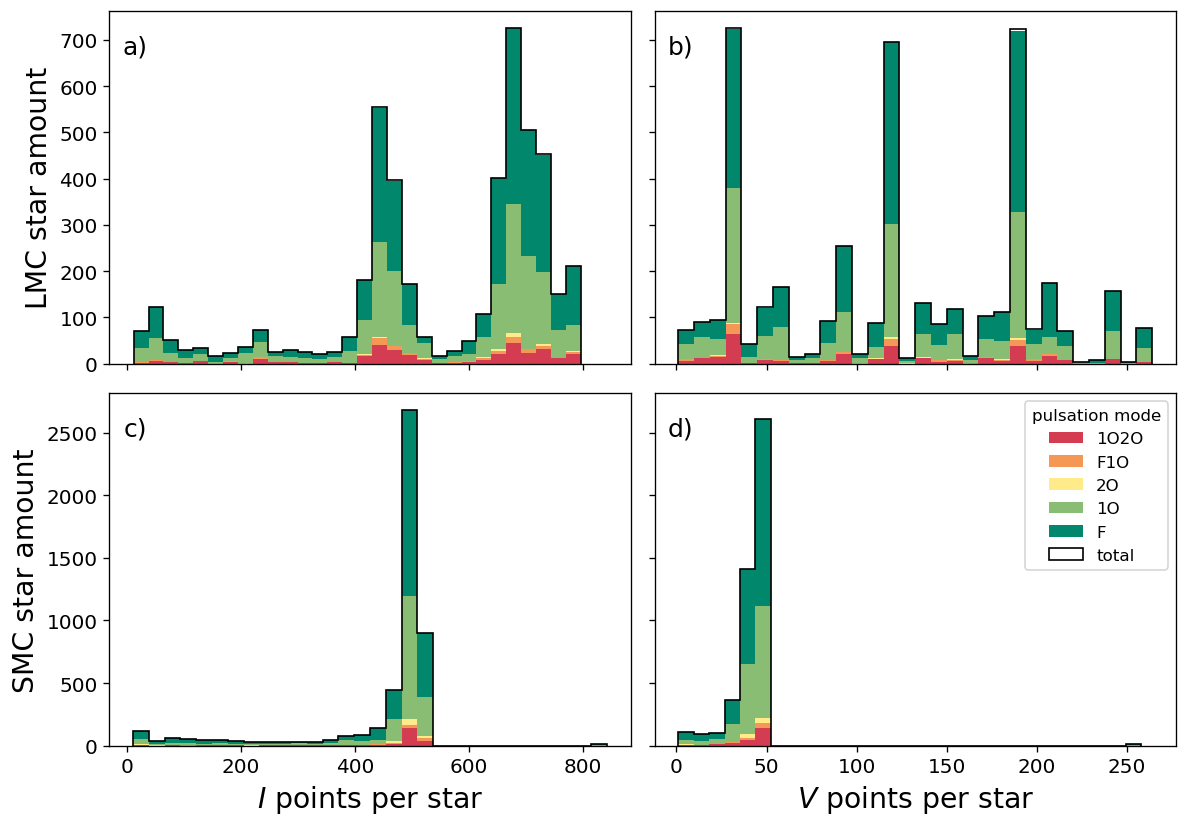

In [ ]:
hist_options = dict(stacked=True,bins=30,color=colors,label=labels["selected"])
total_hist_options = dict(bins=30,histtype="step",color='k',label="total")

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,7),sharey="row",sharex="col")

for i,cloud in enumerate(["lmc","smc"]):
    ax = axes[i]
    
    plt.sca(ax[0])
    plt.hist([tables[cloud][s].nI for s in labels["selected"]], **hist_options)
    plt.hist(tables[cloud]["total"].nI, **total_hist_options)
    if i:
        plt.xlabel(r"$I$ points per star")
    plt.ylabel(fr"{cloud.upper()} star amount")
    
    plt.sca(ax[1])
    plt.hist([tables[cloud][s].nV for s in labels["selected"]], **hist_options)
    plt.hist(tables[cloud]["total"].nV, **total_hist_options)
    if i:
        plt.xlabel(r"$V$ points per star")

sublabels = "abcd"
for i,ax in enumerate(axes.ravel()):
    plt.sca(ax)
    plt.text(0.05, 0.9, sublabels[i]+")", fontsize=15,
             horizontalalignment='center', verticalalignment='center', 
             transform=ax.transAxes)

plt.sca(axes[1,1])
plt.legend(title="pulsation mode")
plt.tight_layout()

Text(0.5, 1.0, 'OGLE-LMC-CEP-1234')

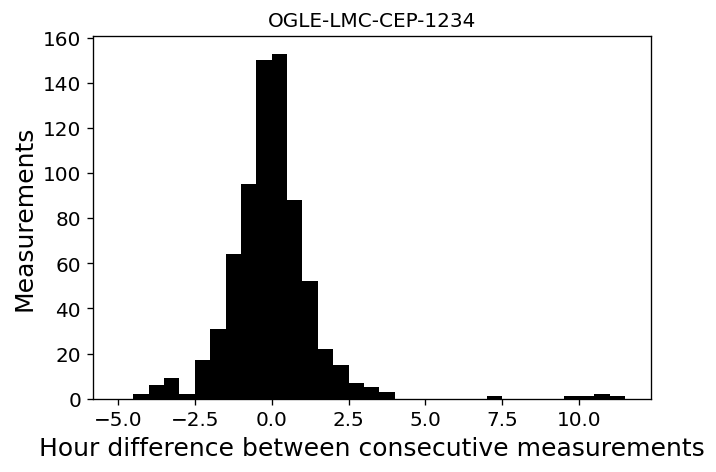

In [222]:
t,mag,err = np.loadtxt("ogle4/OCVS/lmc/cep/phot/I/OGLE-LMC-CEP-1234.dat",unpack=True)
dist = np.mod(np.diff(t)+0.5,1)-0.5
plt.hist(24*dist,np.arange(-5,12,0.5),color='k');
plt.xlabel("Hour difference between consecutive measurements",fontsize=15)
plt.ylabel("Measurements",fontsize=15)
plt.title("OGLE-LMC-CEP-1234")